In [1]:
import numpy as np
import realization as rn
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 6)

In [17]:
#kout, stats, hists = rn.ng.driver(dims=(1024,1024), fNL=1, Pk=-1, eq_vol=True, ng_pow=-1, fG=0.0)

def trans(g):
    h = 1./(10.+g)
    return h-np.mean(h)

kout, stats, hists = rn.ng.driver(dims=(1024,1024), fNL=1, Pk=-0.5, eq_vol=True, transform=trans)


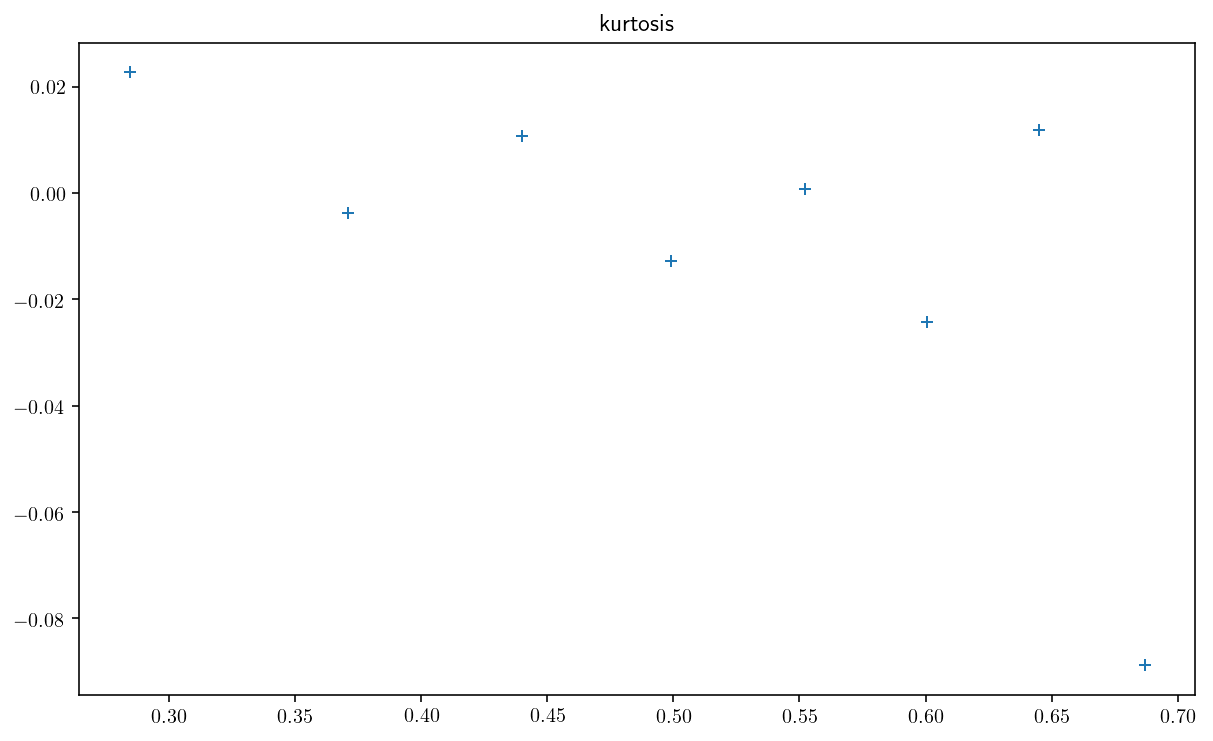

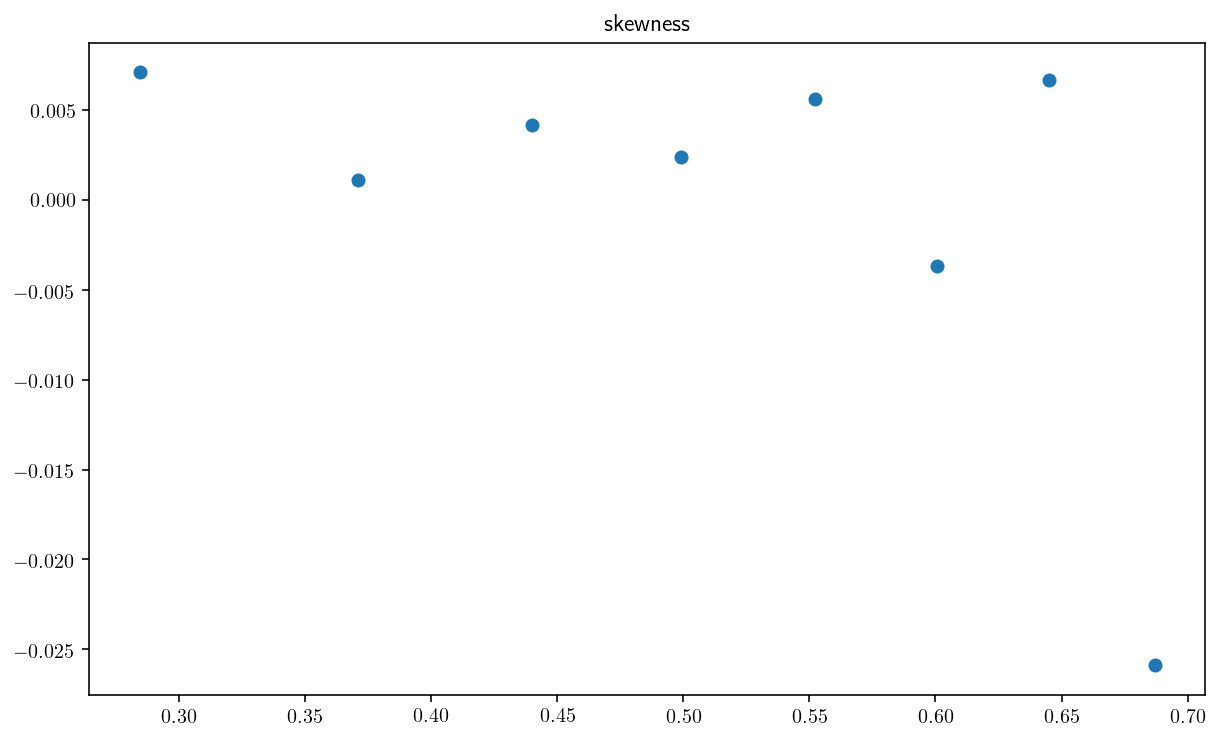

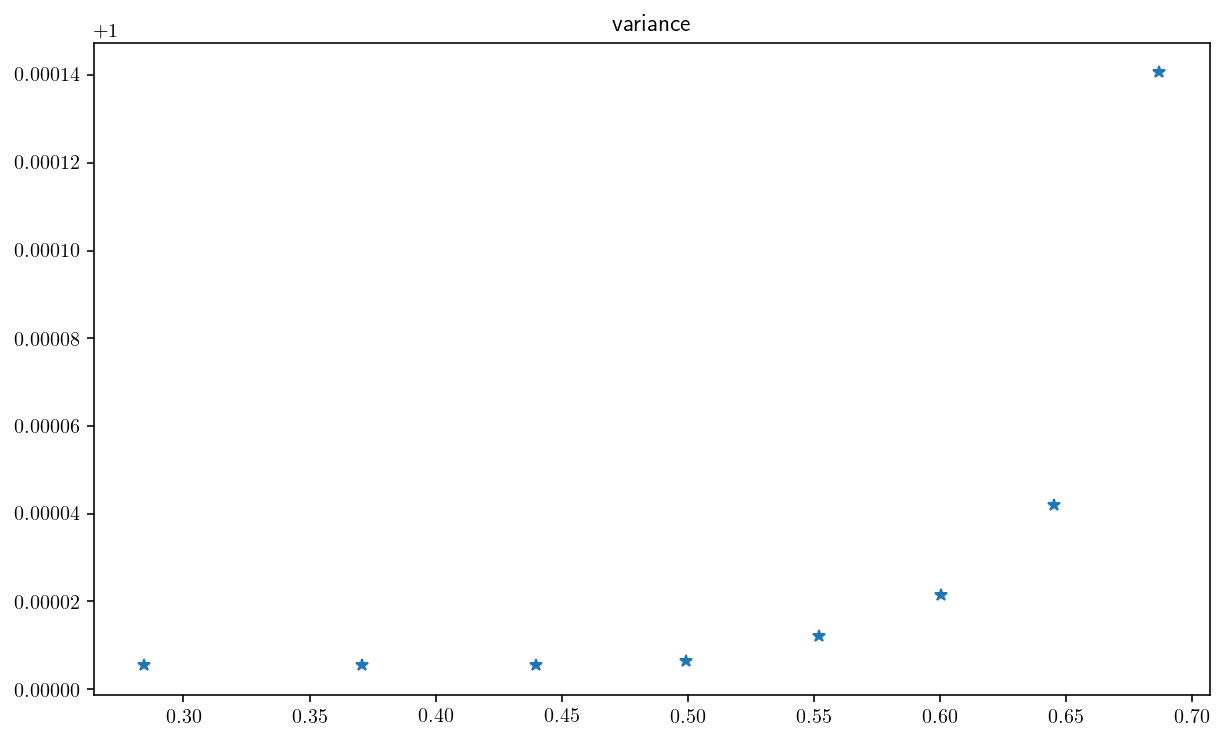

In [18]:
plt.figure()
i1 = 1
plt.plot(kout[i1:], stats.T[3][i1:], '+'); plt.title('kurtosis')
plt.figure()
plt.plot(kout[i1:], stats.T[2][i1:], 'o'); plt.title('skewness')
plt.figure()
plt.plot(kout[i1:], stats.T[1][i1:], '*'); plt.title('variance')

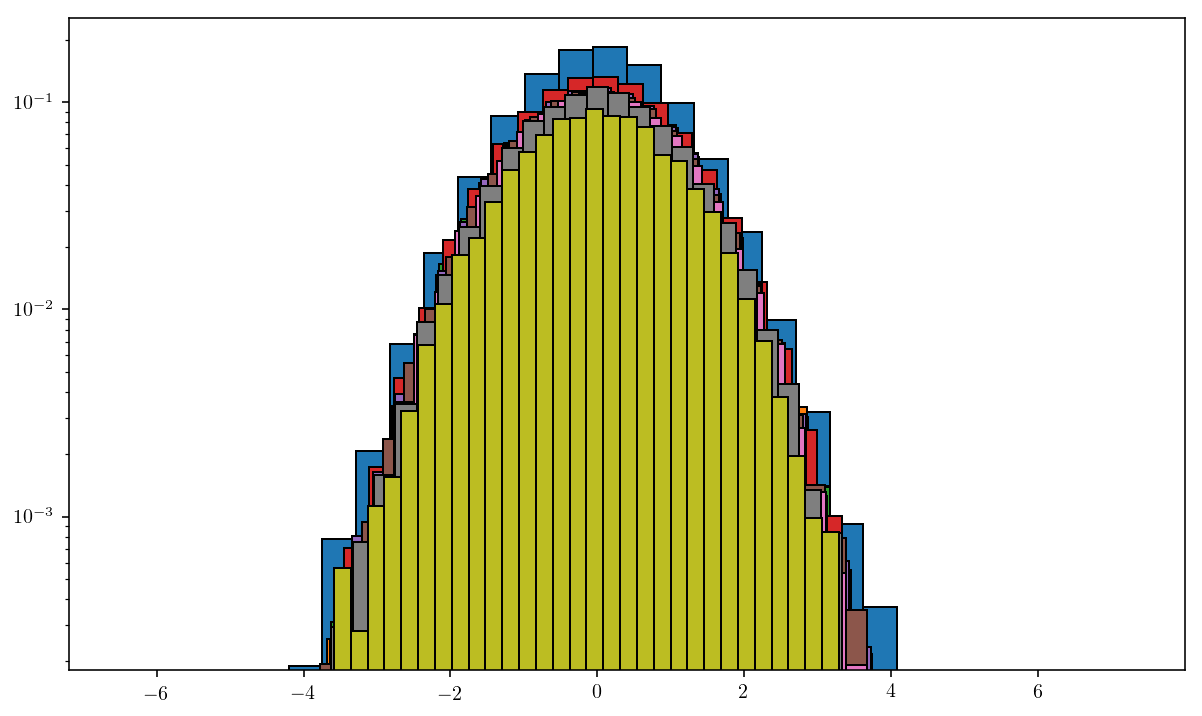

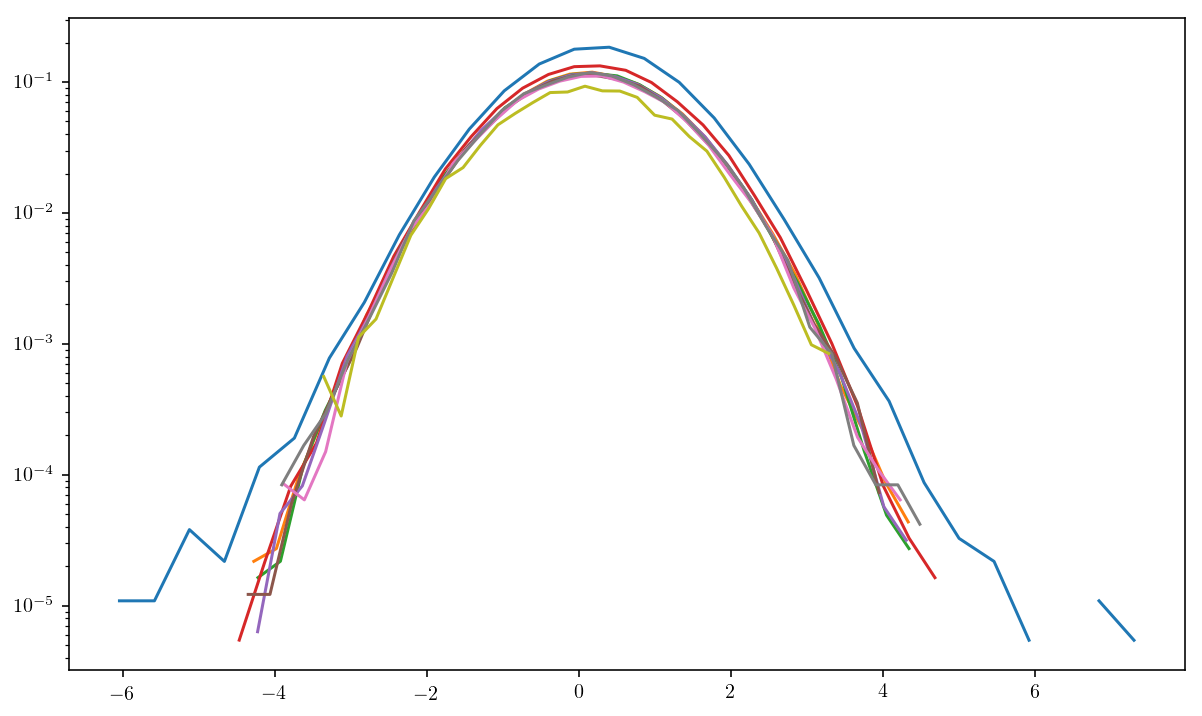

In [19]:
## see http://stackoverflow.com/questions/44003552/matplotlib-histogram-from-numpy-histogram-output
for frq, edges in hists[0:]:
    frq = np.array(frq,dtype=np.float)
    frq /= frq.sum()
    plt.bar(edges[:-1], frq, width=np.diff(edges), ec="k", align="edge", log=True)
    # plt.figure()
    
plt.figure()
for frq, edges in hists[0:]:
    frq = np.array(frq,dtype=np.float)
    frq /= frq.sum()
    ctrs = edges[:-1] + np.diff(edges)
    plt.semilogy(ctrs, frq)
    # plt.figure()

In [5]:
rlzn_fourier0, rlzn_config0 = rn.ng.local_fNL((4096,4096), 1, -2, return_config=True, ng_pow=-1, fG=0)
rlzn_fourier100, rlzn_config100 = rn.ng.local_fNL((4096,4096), 1, -2, return_config=True, ng_pow=2)

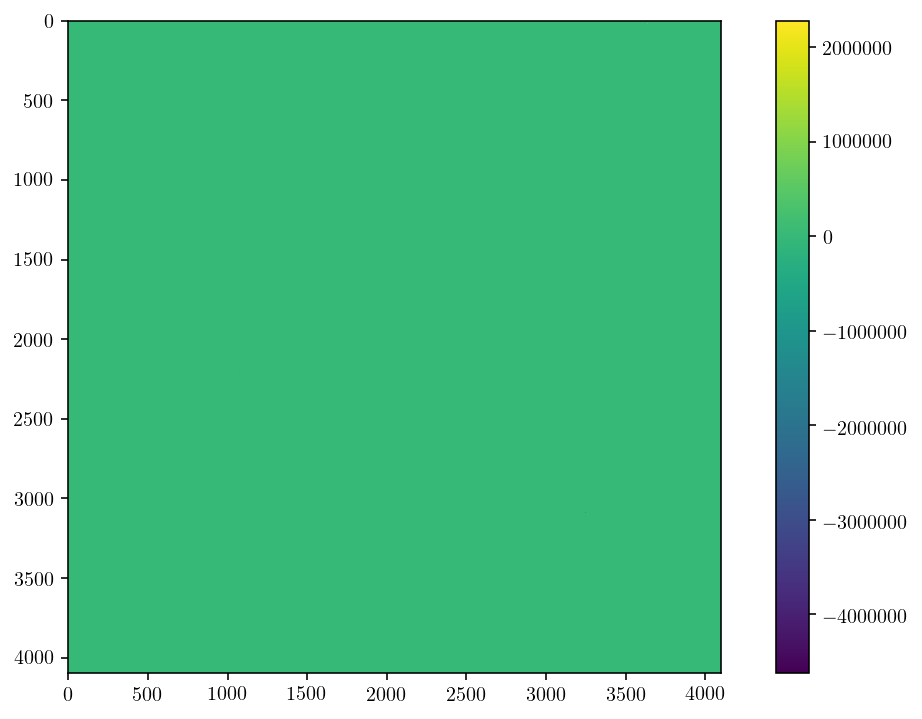

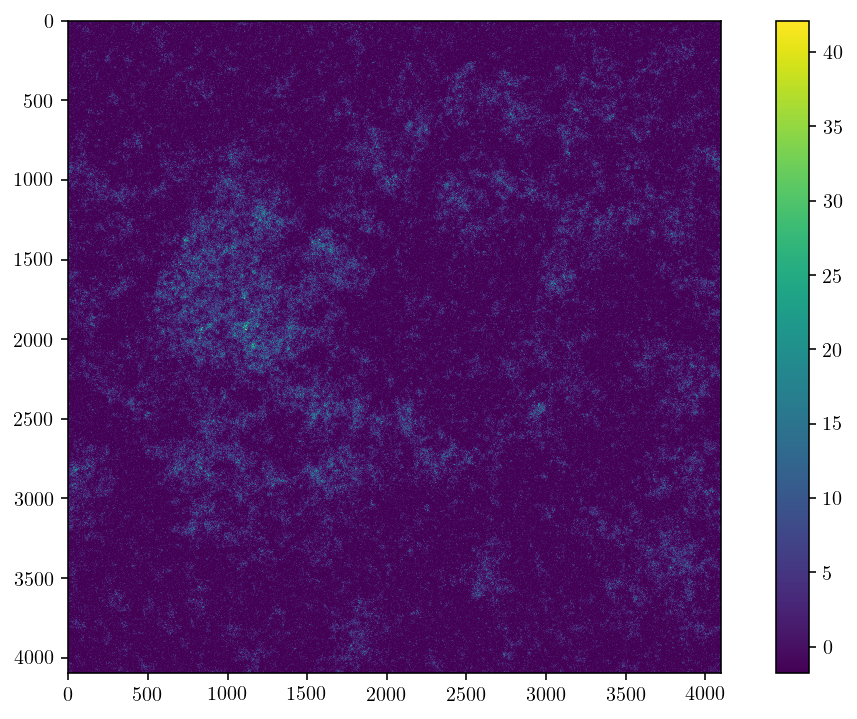

In [6]:
plt.imshow(rlzn_config0); plt.axis("scaled"); plt.colorbar()
plt.figure()
plt.imshow(rlzn_config100); plt.axis("scaled"); plt.colorbar()

(-0.5, 2048.5, -0.5, 2047.5)

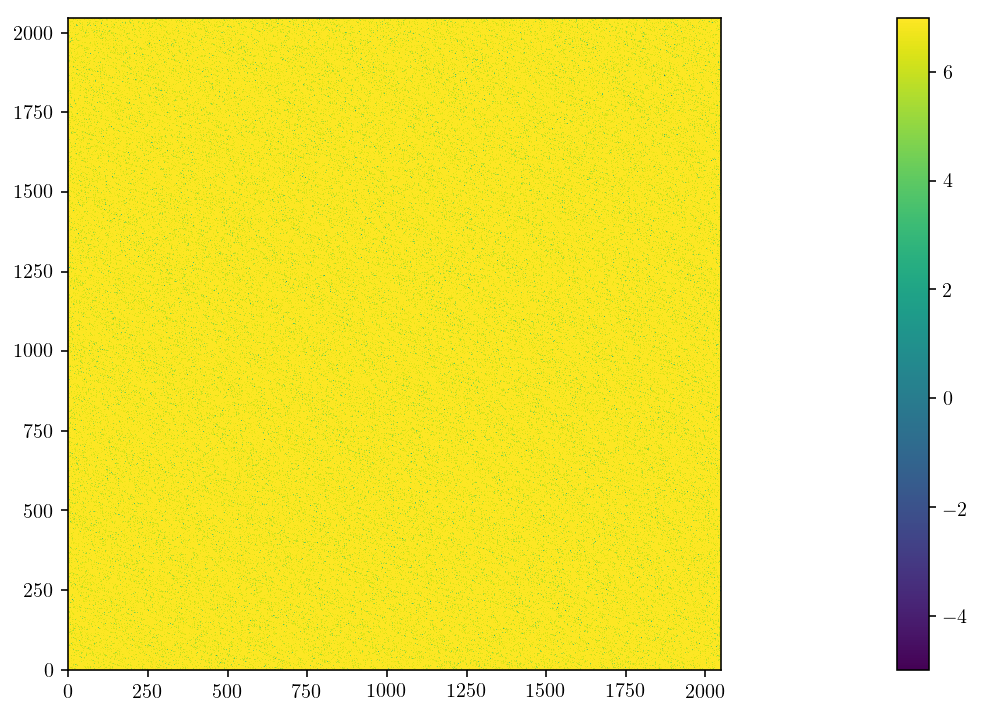

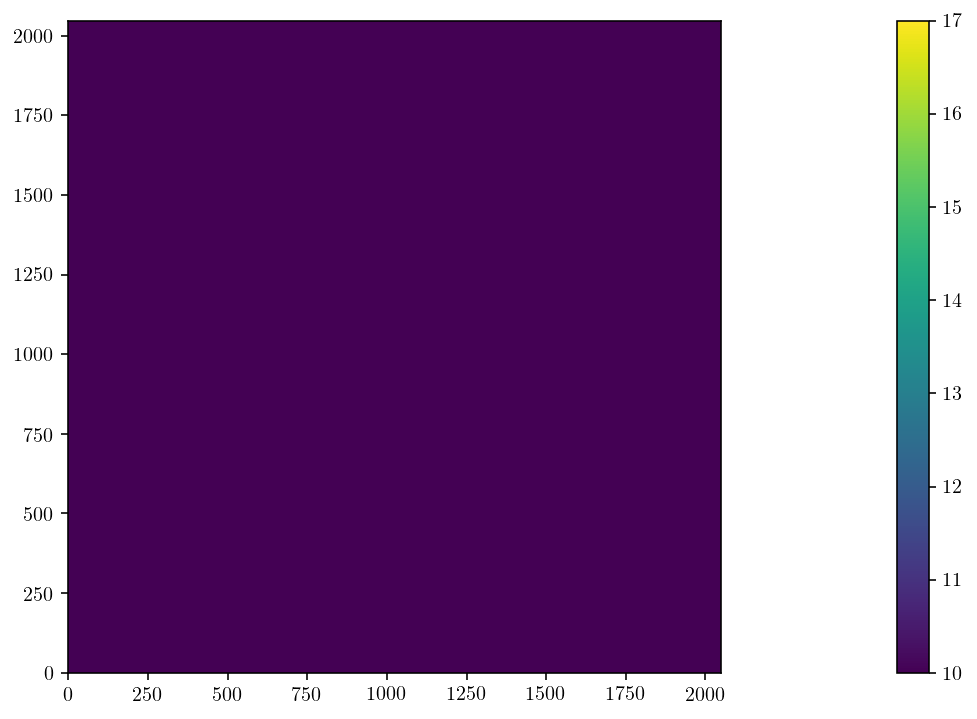

In [7]:
plt.imshow(np.log(np.abs(rlzn_fourier0[:rlzn_fourier0.shape[0]/2])/4096),vmin=-5,vmax=7, origin='lower'); plt.colorbar(); plt.axis("scaled")
plt.figure()
plt.imshow(np.log(np.abs(rlzn_fourier100[:rlzn_fourier100.shape[0]/2])/4096), vmin=10,vmax=17, origin='lower'); plt.colorbar(); plt.axis("scaled")

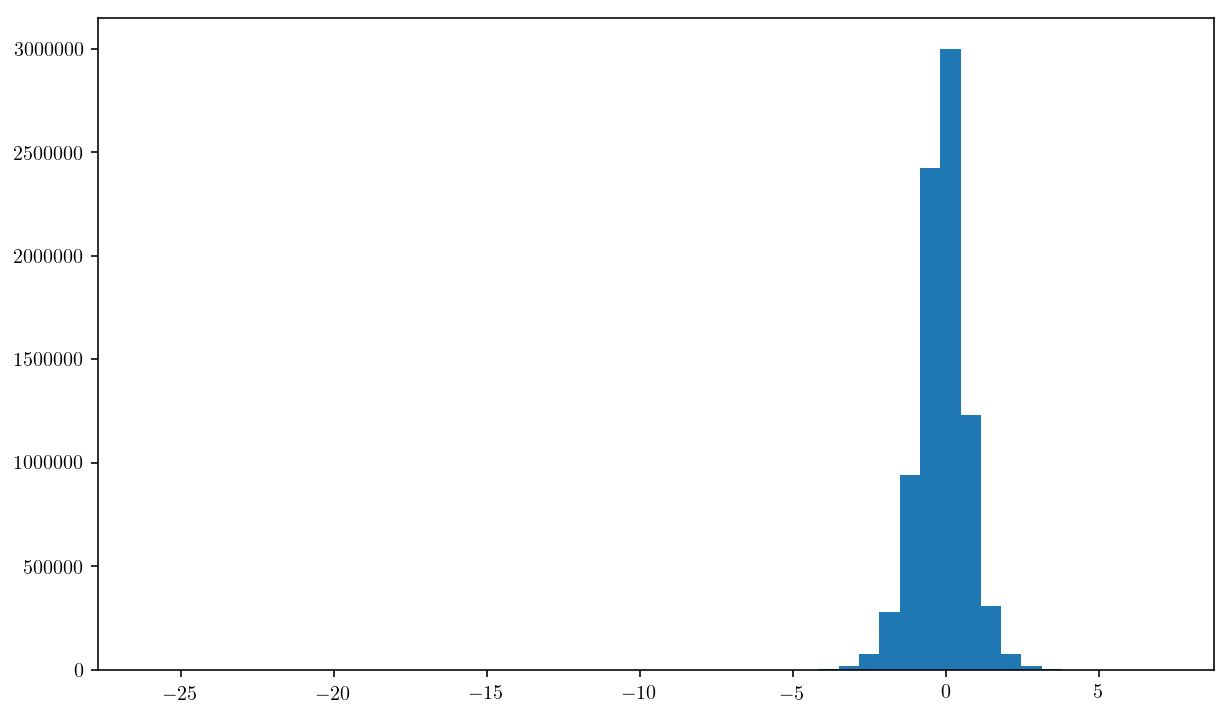

In [8]:
_=plt.hist(np.log(np.abs(rlzn_fourier100)/4096).ravel(), bins=50)

In [9]:
plt.imshow?

In [10]:
rlzn_fourier0[:rlzn_fourier.shape[0]/2].shape

NameError: name 'rlzn_fourier' is not defined

In [12]:
q(3)

NameError: name 'q' is not defined